In [30]:
import os
import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.cluster import KMeans
from lameg.surf import create_surf_gifti, compute_mesh_distances
from lameg.viz import show_surface
from lameg.util import convert_native_to_fsaverage, get_BB_layer_boundaries
from utilities.utils import *
from joblib import Parallel, delayed
from scipy.interpolate import interp2d
from scipy.ndimage import gaussian_filter1d
from base64 import b64decode
from PIL import Image
import io
from matplotlib.gridspec import GridSpec

In [2]:
fig_output_dir='/home/bonaiuto/laminar_erf/output/figures/'

In [3]:
fs_subjects_dir = os.getenv('SUBJECTS_DIR')

# Load FS-average
fsaverage_vertices, fsaverage_faces = nib.freesurfer.read_geometry(
    os.path.join(fs_subjects_dir, 'fsaverage','surf','lh.pial_semi_inflated')
)
fsaverage = create_surf_gifti(fsaverage_vertices, fsaverage_faces)

In [4]:
subj_colors=[
    [27,158,119],
    [217,95,2],
    [117,112,179],
    [231,41,138],
    [102,166,30],
    [230,171,2],
    [166,118,29],
    [102,102,102]
]
cam_mat=[-30, 8, 200,
         -32, -18, 15,
         0, 1, 0]

In [5]:
n_layers=11
l_idx=np.arange(n_layers)    

In [12]:
base_data_dir='/home/bonaiuto/laminar_erf/output/'
results_fname=os.path.join(base_data_dir, 'multilaminar_results_motor-epo.npz')
if os.path.exists(results_fname):
    results = np.load(results_fname,allow_pickle=True)
else:
    results={
        'subject_idx': [],
        'ses_idx': [],
        'cluster_idx': [],
        'native_pial_coord': [],
        'native_vertex': [],
        'fsave_pial_coord': [],
        'fsave_vertex': [],
        'ts': [],
        'bilaminar_fe': [],
        'multilaminar_fe': [],
        'layer_ave_fe': [],
        'layer_bounds': []
    }

    kdtree = KDTree(fsaverage_vertices)

    subj_paths=sorted(glob.glob(os.path.join(base_data_dir,'sub-*')))
    for s_idx,subj_path in enumerate(subj_paths):
        subject=os.path.split(subj_path)[-1]
        ses_paths=sorted(glob.glob(os.path.join(subj_path,'ses-*')))    

        surf_dir = os.path.join(
            '/home/common/bonaiuto/cued_action_meg/derivatives/processed',
            subject,
            'surf'
        )
        orig_pial = nib.load(os.path.join(surf_dir, 'pial.gii'))
        ds_pial=nib.load(os.path.join(surf_dir, 'pial.ds.gii'))

        for ses_idx, ses_path in enumerate(ses_paths):
            session=os.path.split(ses_path)[-1]    

            print(f'{subject} - {session}')
            fname=os.path.join(ses_path,'localizer_results_motor-epo.npz')

            with np.load(fname) as data:
                cluster_vtx=data['cluster_vtx']
                cluster_coord=data['cluster_coord']
                cluster_ts=data['cluster_ts']
                ts_time=data['ts_time']                

            for c_idx in range(len(cluster_vtx)):
                subj_vtx=cluster_vtx[c_idx]
                subj_coord=cluster_coord[c_idx,:]
                pial_coord=ds_pial.darrays[0].data[subj_vtx,:]
                hemi, fsave_vtx = convert_native_to_fsaverage(subject, surf_dir, pial_coord)
                if hemi=='rh':
                    fsave_vtx += lh_fsaverage_vertices.shape[0]
                fsave_coord = fsaverage.darrays[0].data[fsave_vtx,:]

                results['subject_idx'].append(s_idx)
                results['ses_idx'].append(ses_idx)
                results['cluster_idx'].append(c_idx)
                results['native_pial_coord'].append(pial_coord)
                results['native_vertex'].append(subj_vtx)
                results['fsave_pial_coord'].append(fsave_coord)
                results['fsave_vertex'].append(fsave_vtx)
                ts=cluster_ts[c_idx,0,:]
                t0=np.argmin(np.abs(ts_time-0))
                if ts[t0]>0:
                    ts *= -1
                results['ts'].append(ts)

            fname=os.path.join(ses_path,'multilaminar_results_motor-epo.npz')
            with np.load(fname) as data:                    
                cluster_vtx=data['cluster_vtx']
                cluster_layer_fs=data['cluster_layer_fs']
                fe_time=data['fe_time']
            for c_idx in range(len(cluster_vtx)):
                subj_vtx=cluster_vtx[c_idx]
                pial_coord=ds_pial.darrays[0].data[subj_vtx,:]

                boundaries=get_BB_layer_boundaries(subject, surf_dir, pial_coord)

                Fs=np.squeeze(cluster_layer_fs[c_idx,:,:])

                bilaminar_fe=smooth_signal(Fs[0,:]-Fs[-1,:])                

                # Compute the relative free energy for each layer model, compared to the worst model at each time step
                F_diff = np.zeros((Fs.shape[0],Fs.shape[1]))
                for t in range(Fs.shape[1]):
                    minF = np.min(Fs[:,t])
                    F_diff[:,t] = Fs[:,t]-minF                        
                for l in range(F_diff.shape[0]):
                    F_diff[l,:]=smooth_signal(F_diff[l,:])

                layer_twothree_lims=[int(boundaries[0]*(n_layers-1)), int(boundaries[2]*(n_layers-1))]
                layer_twothree_idx=np.where((l_idx>=layer_twothree_lims[0]) & (l_idx<=layer_twothree_lims[1]))[0]
                layer_four_lims=[int(boundaries[2]*(n_layers-1)), int(boundaries[3]*(n_layers-1))]
                layer_four_idx=np.where((l_idx>=layer_four_lims[0]) & (l_idx<=layer_four_lims[1]))[0]
                layer_five_lims=[int(boundaries[3]*(n_layers-1)), int(boundaries[4]*(n_layers-1))]
                layer_five_idx=np.where((l_idx>=layer_five_lims[0]) & (l_idx<=layer_five_lims[1]))[0]
                layer_Fs = np.vstack([
                    np.mean(Fs[layer_twothree_idx,:],axis=0),
                    np.mean(Fs[layer_four_idx,:],axis=0),
                    np.mean(Fs[layer_five_idx,:],axis=0)
                ])
                layer_F_diff = np.zeros((layer_Fs.shape[0],layer_Fs.shape[1]))
                for t in range(layer_Fs.shape[1]):
                    minF = np.min(layer_Fs[:,t])
                    layer_F_diff[:,t] = layer_Fs[:,t]-minF                        
                for l in range(layer_F_diff.shape[0]):
                    layer_F_diff[l,:]=smooth_signal(layer_F_diff[l,:], threshold=3)

                results['layer_bounds'].append(boundaries)
                results['bilaminar_fe'].append(bilaminar_fe)
                results['multilaminar_fe'].append(F_diff)
                results['layer_ave_fe'].append(layer_F_diff)

    for key in results:
        results[key]=np.array(results[key])
        
    np.savez(results_fname, **results)

In [13]:
coord_colors=[]


subj_paths=sorted(glob.glob(os.path.join(base_data_dir,'sub-*')))
for s_idx,subj_path in enumerate(subj_paths):
    ses_paths=sorted(glob.glob(os.path.join(subj_path,'ses-*')))    
    
    for ses_path in ses_paths:
        session=os.path.split(ses_path)[-1]    
        
        fname=os.path.join(ses_path,'localizer_results_motor-epo.npz')
        with np.load(fname) as data:
            cluster_vtx=data['cluster_vtx']

        for c_idx in range(len(cluster_vtx)):
            coord_colors.append(subj_colors[s_idx])

plot = show_surface(
    fsaverage, 
    info=True, 
    coords=results['fsave_pial_coord'],
    coord_size=2, 
    coord_color=coord_colors,
    camera_view=cam_mat
)

Output()

163842 vertices


In [14]:
plot.fetch_screenshot()

In [15]:
image_data = b64decode(plot.screenshot)

image = Image.open(io.BytesIO(image_data))

image_array = np.array(image)

# Save the image with high DPI
image.save(os.path.join(fig_output_dir, 'subject_localization_motor.png'), format='PNG', dpi=(300, 300))

In [17]:
geo_dist_fname=os.path.join(base_data_dir, 'geo_dist_motor-epo.npy')
if os.path.exists(geo_dist_fname):
    geo_dist = np.load(geo_dist_fname)
else:
    distance_matrix = compute_mesh_distances(fsaverage_vertices.astype(np.float64), fsaverage_faces)

    # Number of vertices for which to compute the distances
    num_vertices = len(results['fsave_vertex'])

    # Parallel computation of geodesic distances
    dist_results = Parallel(n_jobs=-1)(
        delayed(parallel_compute_distances)(i, distance_matrix, results['fsave_vertex']) for i in range(num_vertices))

    # Initialize the geodesic distance matrix and fill it with the results
    geo_dist = np.zeros((num_vertices, num_vertices))
    for i in range(num_vertices):
        geo_dist[i, :] = dist_results[i]
    np.save(geo_dist_fname, geo_dist)

In [18]:
# Apply clustering (e.g., k-means) based on the geodesic distances
kmeans = KMeans(n_clusters=3, random_state=0).fit(geo_dist)

# Get the cluster labels (which data point belongs to which cluster)
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

cluster_colors=[]
for i in cluster_labels:
    cluster_colors.append(subj_colors[i])
plot = show_surface(
    fsaverage, 
    info=True, 
    coords=results['fsave_pial_coord'],
    coord_size=2, 
    coord_color=cluster_colors,
    camera_view=cam_mat
)

Output()

163842 vertices


In [19]:
plot.fetch_screenshot()

In [20]:
image_data = b64decode(plot.screenshot)

image = Image.open(io.BytesIO(image_data))

image_array = np.array(image)

# Save the image with high DPI
image.save(os.path.join(fig_output_dir, 'clusters_motor.png'), format='PNG', dpi=(300, 300))

In [21]:
c_idx=0
idx=np.where(cluster_labels==c_idx)[0]
color=subj_colors[c_idx]
print(len(idx))

plot = show_surface(
    fsaverage, 
    info=True, 
    coords=results['fsave_pial_coord'][idx,:],
    coord_size=2, 
    coord_color=color,
    camera_view=cam_mat
)

50


Output()

163842 vertices


In [22]:
plot.fetch_screenshot()

In [23]:
image_data = b64decode(plot.screenshot)

image = Image.open(io.BytesIO(image_data))

image_array = np.array(image)

# Save the image with high DPI
image.save(os.path.join(fig_output_dir, 'cluster_0_motor.png'), format='PNG', dpi=(300, 300))

In [24]:
c_idx=1
idx=np.where(cluster_labels==c_idx)[0]
color=subj_colors[c_idx]
print(len(idx))

plot = show_surface(
    fsaverage, 
    info=True, 
    coords=results['fsave_pial_coord'][idx,:],
    coord_size=2, 
    coord_color=color,
    camera_view=cam_mat
)

58


Output()

163842 vertices


In [25]:
plot.fetch_screenshot()

In [26]:
image_data = b64decode(plot.screenshot)

image = Image.open(io.BytesIO(image_data))

image_array = np.array(image)

# Save the image with high DPI
image.save(os.path.join(fig_output_dir, 'cluster_1_motor.png'), format='PNG', dpi=(300, 300))

In [31]:
def plot_cluster_multilayer(c_idx, woi=None, include_layer_iv=True):
    
    all_subj_ts=[]
#     all_subj_bilaminar_fe=[]
    all_subj_multilaminar_fe=[]
    all_subj_layer_ave_fe=[]
    
    for s_idx in range(len(subj_paths)):
        if c_idx is None:
            r_idx=np.where((results['subject_idx']==s_idx))[0]
        else:
            r_idx=np.where((cluster_labels==c_idx) & (results['subject_idx']==s_idx))[0]
        if len(r_idx):
            all_subj_ts.append(np.mean(results['ts'][r_idx,:],axis=0))
#             all_subj_bilaminar_fe.append(np.mean(results['bilaminar_fe'][r_idx,:],axis=0))
            all_subj_multilaminar_fe.append(np.mean(results['multilaminar_fe'][r_idx,:,:],axis=0))
            all_subj_layer_ave_fe.append(np.mean(results['layer_ave_fe'][r_idx,:,:],axis=0))
    all_subj_ts=np.array(all_subj_ts)
#     all_subj_bilaminar_fe=np.array(all_subj_bilaminar_fe)
    all_subj_multilaminar_fe=np.array(all_subj_multilaminar_fe)
    all_subj_layer_ave_fe=np.array(all_subj_layer_ave_fe)
    
    
    mean_multilaminar_fe=np.mean(all_subj_multilaminar_fe,axis=0)
    m_bounds=np.mean(results['layer_bounds'],axis=0)

    col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
    fig = plt.figure(figsize=(18,8))
    gs = GridSpec(2, 3, figure=fig)

    ax = fig.add_subplot(gs[:,0])
    img_fname=f'cluster_{c_idx}_motor.png'
    if c_idx is None:
        img_fname=f'cluster_-1_motor.png'
    with Image.open(os.path.join(fig_output_dir, img_fname)) as im:
        image_array = np.array(im)
        ax.imshow(image_array)
        ax.axis('off')
        
    ax = fig.add_subplot(gs[0,1])
    m_ts=np.mean(all_subj_ts,axis=0)
    se_ts=np.std(all_subj_ts,axis=0)/np.sqrt(all_subj_ts.shape[0])
    ax.plot(ts_time,m_ts)
    ax.fill_between(ts_time,m_ts-se_ts,m_ts+se_ts, alpha=0.5)
    ax.axvline(x=0,color='k',linestyle='--')
    if woi is not None:
        ax.set_xlim(woi)
    else:
        ax.set_xlim(ts_time[[0,-1]])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Source density (nA/mm^2)')

#     plt.subplot(2,3,3)
#     m_fe=np.mean(all_subj_bilaminar_fe,axis=0)
#     plt.plot(fe_time,m_fe,linewidth=2)
#     plt.axvline(x=0,color='k',linestyle='--')
#     plt.axhline(y=-3,color='k',linestyle='--')
#     plt.axhline(y=3,color='k',linestyle='--')
#     if woi is not None:
#         plt.xlim(woi)
#     else:
#         plt.xlim(fe_time[[0,-1]])
#     plt.xlabel('Time (ms)')
#     plt.ylabel(r'$\Delta$F')
    
    # Plot relative free energy time series
    ax = fig.add_subplot(gs[0,2])
    for l in range(n_layers):
        ax.plot(fe_time,mean_multilaminar_fe[l,:], label=f'{l}', color=col_r[l,:])
    ax.axvline(x=0, color='k', linestyle='--')
    ax.axhline(y=3, color='k', linestyle='--')
    if woi is not None:
        ax.set_xlim(woi)
    else:
        ax.set_xlim(fe_time[[0,-1]])
    plt.legend()
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel(r'$\Delta$F')

    ax = fig.add_subplot(gs[1,1])
    h=ax.imshow(mean_multilaminar_fe, aspect='auto',extent=[fe_time[0], fe_time[-1], n_layers-1, 0], cmap='plasma')
    for i in range(m_bounds.shape[0]):
        ax.axhline(y=m_bounds[i]*(n_layers-1), color='k', linestyle='--')
    peak_layer=gaussian_filter1d(np.argmax(mean_multilaminar_fe,axis=0).astype(float), 5)
    ax.plot(fe_time, peak_layer, 'w')
    ax.axvline(x=0, color='k', linestyle='--')
    if woi is not None:
        ax.set_xlim(woi)
    else:
        ax.set_xlim(fe_time[[0,-1]])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Layer')
    col_b=plt.colorbar(h)
    col_b.set_label(r'$\Delta$F')
    
    ax = fig.add_subplot(gs[1,2])
    m_layer=np.mean(all_subj_layer_ave_fe[:,0,:],axis=0)
    se_layer=np.std(all_subj_layer_ave_fe[:,0,:],axis=0)/np.sqrt(all_subj_layer_ave_fe.shape[0])
    ax.plot(fe_time, m_layer, color=col_r[0,:], linewidth=3, label='II/III')
    #plt.fill_between(fe_time, m_layer-se_layer, m_layer+se_layer, alpha=0.25, color=col_r[0,:])
    
    if include_layer_iv:
        m_layer=np.mean(all_subj_layer_ave_fe[:,1,:],axis=0)
        se_layer=np.std(all_subj_layer_ave_fe[:,1,:],axis=0)/np.sqrt(all_subj_layer_ave_fe.shape[0])    
        ax.plot(fe_time, m_layer, color=col_r[5,:], linewidth=3, label='IV')
        #plt.fill_between(fe_time, m_layer-se_layer, m_layer+se_layer, alpha=0.25, color=col_r[5,:])

    m_layer=np.mean(all_subj_layer_ave_fe[:,2,:],axis=0)
    se_layer=np.std(all_subj_layer_ave_fe[:,2,:],axis=0)/np.sqrt(all_subj_layer_ave_fe.shape[0])   
    ax.plot(fe_time, m_layer, color=col_r[-1,:], linewidth=3, label='V')
    #plt.fill_between(fe_time, m_layer-se_layer, m_layer+se_layer, alpha=0.25, color=col_r[-1,:])
    
    ax.axvline(x=0, color='k', linestyle='--')
    ax.axhline(y=3, color='k', linestyle='--')
    if woi is not None:
        ax.set_xlim(woi)
    else:
        ax.set_xlim(fe_time[[0,-1]])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel(r'$\Delta$F')
    plt.legend()
    plt.tight_layout()

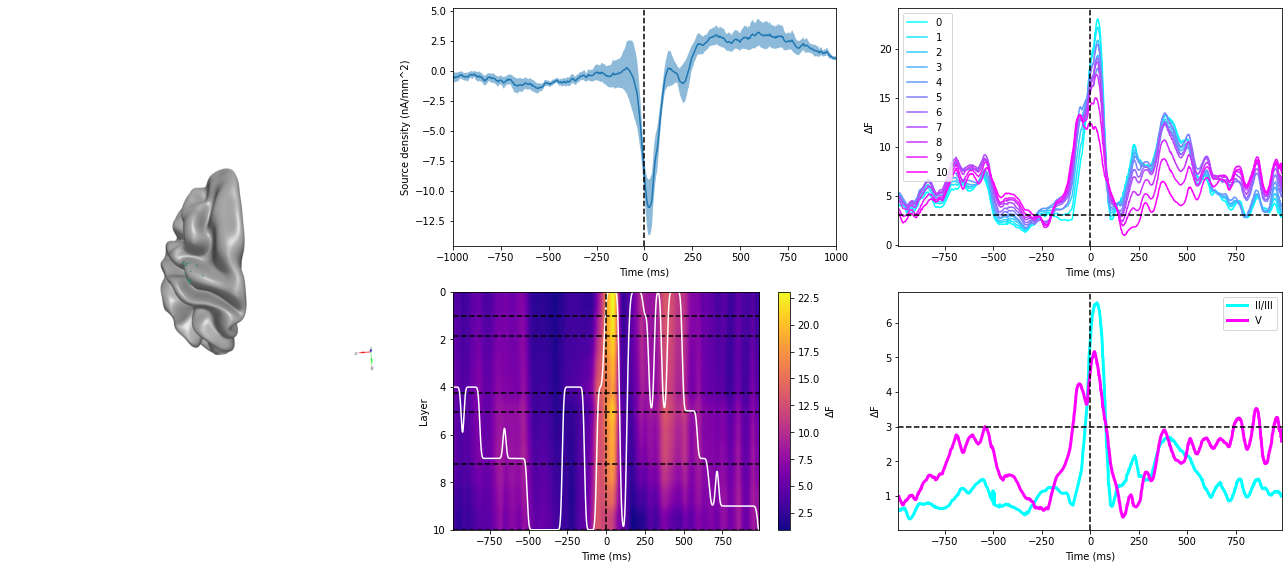

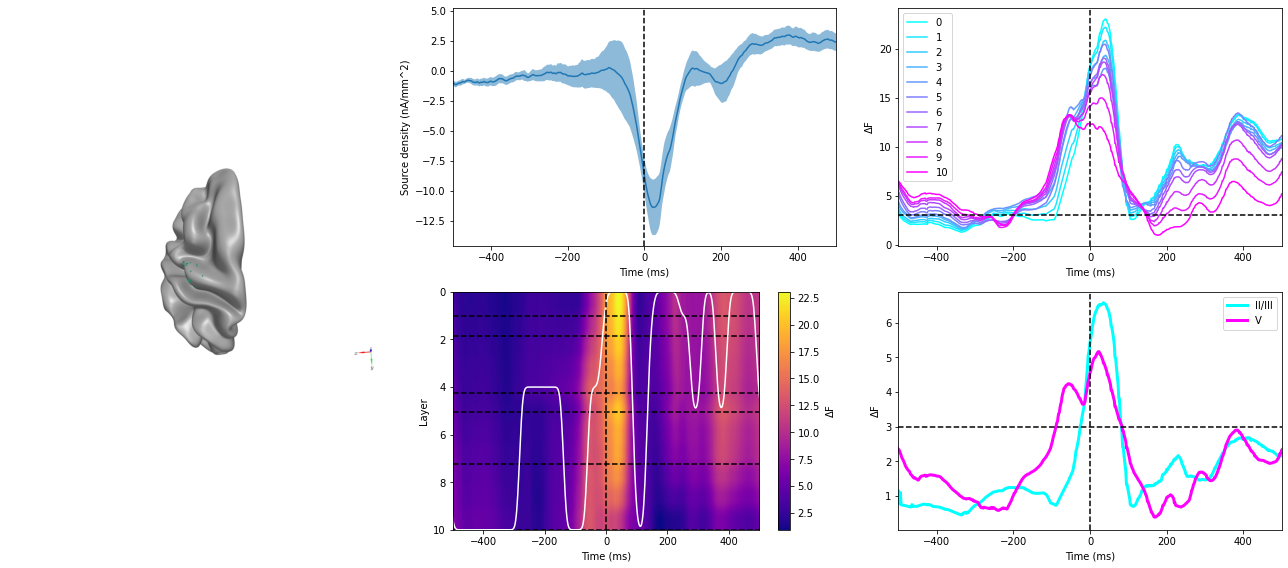

In [32]:
plot_cluster_multilayer(0, include_layer_iv=False)
plot_cluster_multilayer(0, [-500,500], include_layer_iv=False)

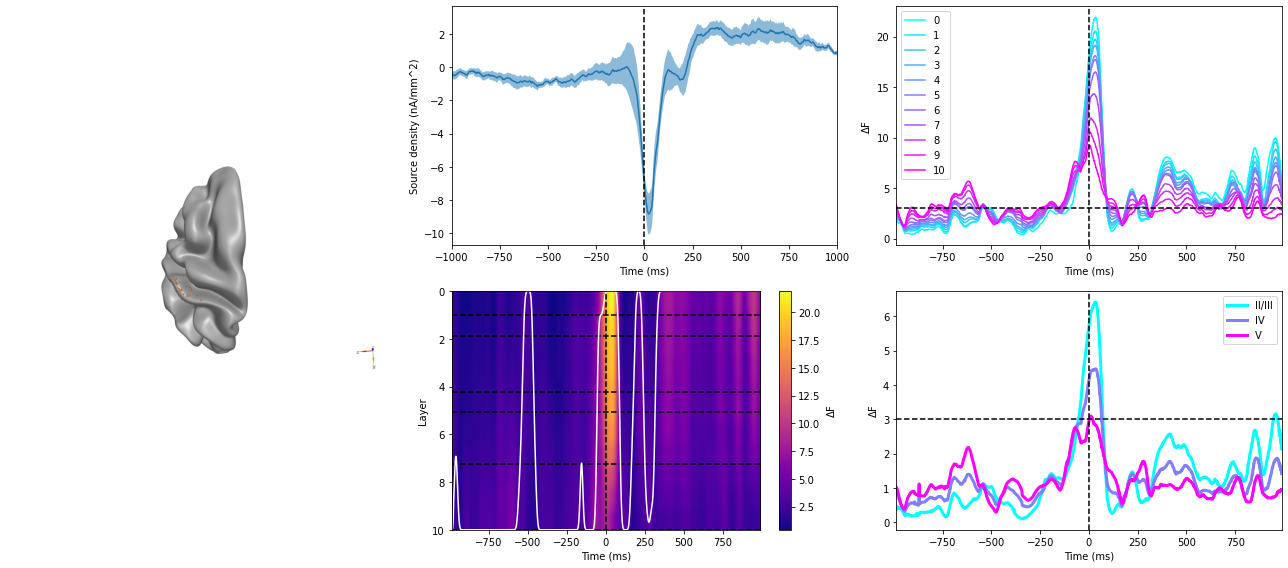

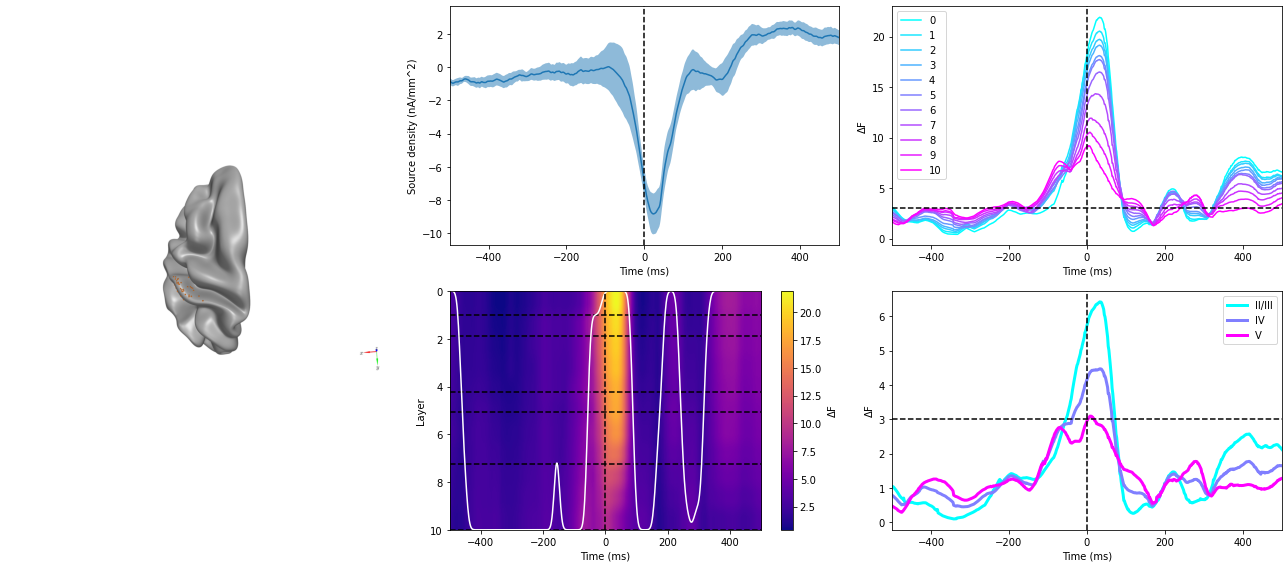

In [33]:
plot_cluster_multilayer(1)
plot_cluster_multilayer(1,[-500,500])